In [1]:
import numpy as np
import matplotlib.pyplot as plt
from metropolis import init, calc_energy, gen_neigh, get_expos, mc_step, calc_err

# %matplotlib widget
plt.rcParams['figure.figsize'] = [7, 4]

In [2]:
net_sizes = [18, 24, 36, 48]
temperatures = np.arange(2, 3, 0.1)

dt = np.dtype([
    ('energy', float), ('energy_err', float),
    ('mag', float), ('mag_err', float),
    ('cv', float), ('cv_err', float),
    ('chi', float), ('chi_err', float)
])
data = np.empty((len(net_sizes), len(temperatures)), dtype=dt)

num_steps = int(1.1 * 10**5)
thermaliz_time = 10**4
n_boxes = 10
m = (num_steps - thermaliz_time)/n_boxes

for L_index, L in enumerate(net_sizes):
  N = L**2
  spins = init(N)
  neigh = gen_neigh(L)
  energy, mag = calc_energy(spins, neigh)

  for t_index, T in enumerate(temperatures):
    expos = get_expos(T)
    
    # the next variables store the expected values calculated in each box
    energy_boxes = []
    energy2_boxes = []
    mag_boxes = []
    mag2_boxes = []
    cv_boxes = []
    chi_boxes = []

    en_sum = 0
    en2_sum = 0
    mag_sum = 0
    mag2_sum = 0

    for j in range(num_steps):
      spins, energy, mag = mc_step(spins, energy, mag, neigh, expos)

      if (j < thermaliz_time): continue

      if (j % (m - 1) == 0):
        energy_box_i = en_sum/m
        energy2_box_i = en2_sum/m
        mag_box_i = mag_sum/m
        mag2_box_i = mag2_sum/m
        
        energy_boxes.append(energy_box_i)
        energy2_boxes.append(energy2_box_i)
        mag_boxes.append(mag_box_i)
        mag2_boxes.append(mag2_box_i)
        
        cv_boxes.append((energy2_box_i - energy_box_i**2) / (T**2 * N))
        chi_boxes.append((mag2_box_i - mag_box_i**2) / (T * N))

        en_sum = 0
        en2_sum = 0
        mag_sum = 0
        mag2_sum = 0

      en_sum += energy
      en2_sum += energy**2
      mag_sum += abs(mag)
      mag2_sum += mag**2

    exp_energy = np.sum(energy_boxes)/n_boxes
    exp_mag = np.sum(mag_boxes) / n_boxes
    exp_cv = np.sum(cv_boxes) / n_boxes
    exp_chi = np.sum(chi_boxes) / n_boxes

    data[L_index][t_index]['energy'] = exp_energy
    data[L_index][t_index]['energy_err'] = calc_err(exp_energy, energy_boxes, n_boxes)
    data[L_index][t_index]['mag'] = exp_mag
    data[L_index][t_index]['mag_err'] = calc_err(exp_mag, mag_boxes, n_boxes)
    data[L_index][t_index]['cv'] = exp_cv
    data[L_index][t_index]['cv_err'] = calc_err(exp_cv, cv_boxes, n_boxes)
    data[L_index][t_index]['chi'] = exp_chi
    data[L_index][t_index]['chi_err'] = calc_err(exp_chi, chi_boxes, n_boxes)


In [3]:
def plot_over_T(key, err_key, ylabel, data, temperatures, net_sizes):
    fig, ax = plt.subplots()
    for i, L in enumerate(net_sizes):
        values = [row[key] for row in data[i, :]]
        err = [row[err_key] for row in data[i, :]]
        ax.errorbar(temperatures, values, yerr = err, label=f'{L}x{L}', linewidth=0.8)
    ax.set_ylabel(ylabel)
    ax.set_xlabel('Temperature')
    ax.legend()


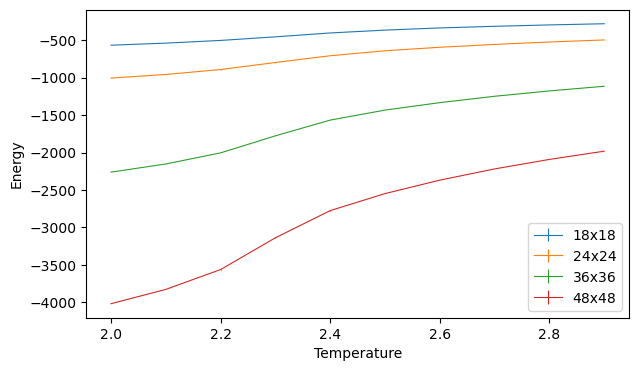

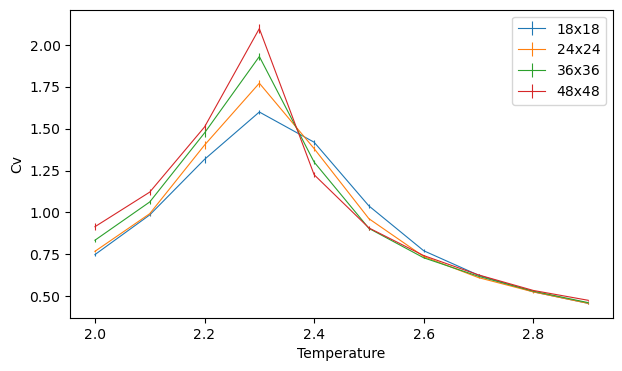

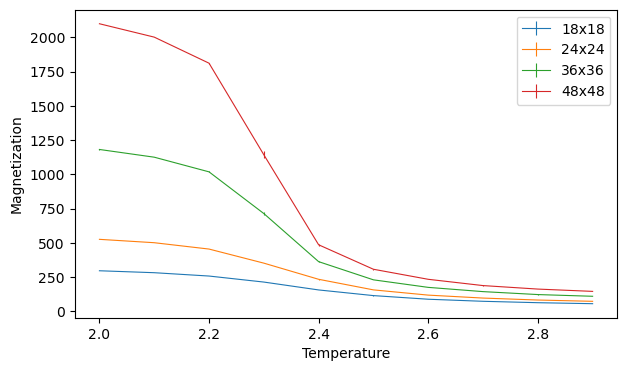

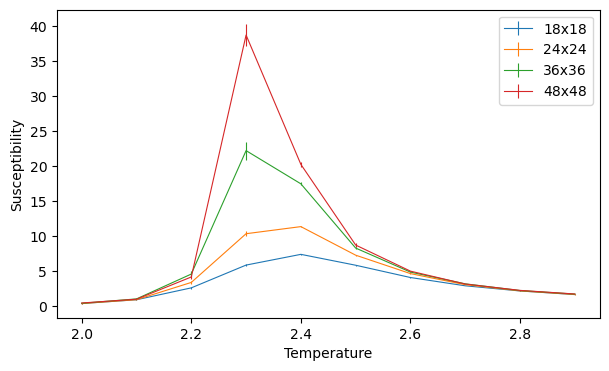

In [4]:
plot_over_T('energy', 'energy_err', 'Energy', data, temperatures, net_sizes)
plot_over_T('cv', 'cv_err', 'Cv', data, temperatures, net_sizes)

plot_over_T('mag', 'mag_err', 'Magnetization', data, temperatures, net_sizes)
plot_over_T('chi', 'chi_err', 'Susceptibility', data, temperatures, net_sizes)